In [34]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from statsmodels.tsa.seasonal import seasonal_decompose

In [35]:
dffir = pd.read_csv(r"D:\KRK Datathon\datathon\Predictive Crime Analytics\FIR_Details_Data.csv")
print(dffir['CrimeGroup_Name'].unique())
print(len(dffir['CrimeGroup_Name'].unique()))

C:\Users\prana\AppData\Local\Temp\ipykernel_15660\645683363.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  dffir = pd.read_csv(r"D:\KRK Datathon\datathon\Predictive Crime Analytics\FIR_Details_Data.csv")


['POCSO' 'KARNATAKA POLICE ACT 1963' 'MOTOR VEHICLE ACCIDENTS NON-FATAL'
 'MOTOR VEHICLE ACCIDENTS FATAL' 'THEFT' 'CrPC' 'CRUELTY BY HUSBAND'
 'ATTEMPT TO MURDER' 'CHEATING' 'Karnataka State Local Act' 'ELECTION'
 ' REPRESENTATION OF PEOPLE ACT 1951 & 1988' 'MOLESTATION'
 'MISSING PERSON' 'CASES OF HURT' 'FORGERY'
 'SCHEDULED CASTE AND THE SCHEDULED TRIBES ' 'BURGLARY - NIGHT'
 'NEGLIGENT ACT' 'MURDER' 'RIOTS' 'Attempting to commit offences'
 'KIDNAPPING AND ABDUCTION' 'EXPLOSIVES'
 'EXPOSURE AND ABANDONMENT OF CHILD' 'ARSON' 'CONSUMER'
 'OFFENCES AGAINST PUBLIC SERVANTS (Public servant is a victim)'
 'CRIMES RELATED TO WOMEN' 'DEATHS DUE TO RASHNESS/NEGLIGENCE'
 'COMMUNAL / RELIGION   ' 'DOWRY DEATHS' 'CRIMINAL BREACH OF TRUST'
 'DACOITY' ' PREVENTION OF DAMAGE TO PUBLIC PROPERTY ACT 1984'
 'BURGLARY - DAY' 'ANIMAL' 'MISCHIEF'
 'INSULTING MODESTY OF WOMEN (EVE TEASING)' 'CRIMINAL TRESPASS'
 'CRIMINAL INTIMIDATION' 'CRIMINAL CONSPIRACY' 'SUICIDE'
 'NARCOTIC DRUGS & PSHYCOTROPIC SUBSTAN

In [36]:
countlst = (dffir['CrimeGroup_Name'].value_counts()).to_string()
print(countlst)

CrimeGroup_Name
MOTOR VEHICLE ACCIDENTS NON-FATAL                                              245780
THEFT                                                                          160669
CrPC                                                                           140245
CASES OF HURT                                                                  127429
MISSING PERSON                                                                 126237
KARNATAKA POLICE ACT 1963                                                      108660
Karnataka State Local Act                                                       91769
MOTOR VEHICLE ACCIDENTS FATAL                                                   83883
 CYBER CRIME                                                                    79756
CHEATING                                                                        49148
MOLESTATION                                                                     43300
PUBLIC SAFETY                         

In [37]:
# Create new column 'year_month' by combining year and month
dffir['year_month'] = pd.to_datetime(dffir['Year'].astype(str) + '-' + dffir['Month'].astype(str), format='%Y-%m')

# Filter for POCSO cases and count them by year_month
pocso_count = dffir[dffir['CrimeGroup_Name'] == 'POCSO'].groupby('year_month').size().to_frame(name='count')
pocso_count = pocso_count.sort_values(by='year_month')
# Print result (or alternatively you can return the 'pocso_count' dataframe)
print(pocso_count)
pocso_count.to_csv('karnataka_pocso_count.csv', index=True)

            count
year_month       
2016-01-01    149
2016-02-01    128
2016-03-01    150
2016-04-01    149
2016-05-01    169
...           ...
2023-11-01    296
2023-12-01    392
2024-01-01    305
2024-02-01    278
2024-03-01     55

[99 rows x 1 columns]


In [38]:
dfkarnatakaposco = pd.read_csv("karnataka_pocso_count.csv",index_col='year_month',parse_dates=True)
dfkarnatakaposco.index.freq='MS'
dfkarnatakaposco.head()

,count
year_month,
2016-01-01,149
2016-02-01,128
2016-03-01,150
2016-04-01,149
2016-05-01,169


<Axes: xlabel='year_month'>

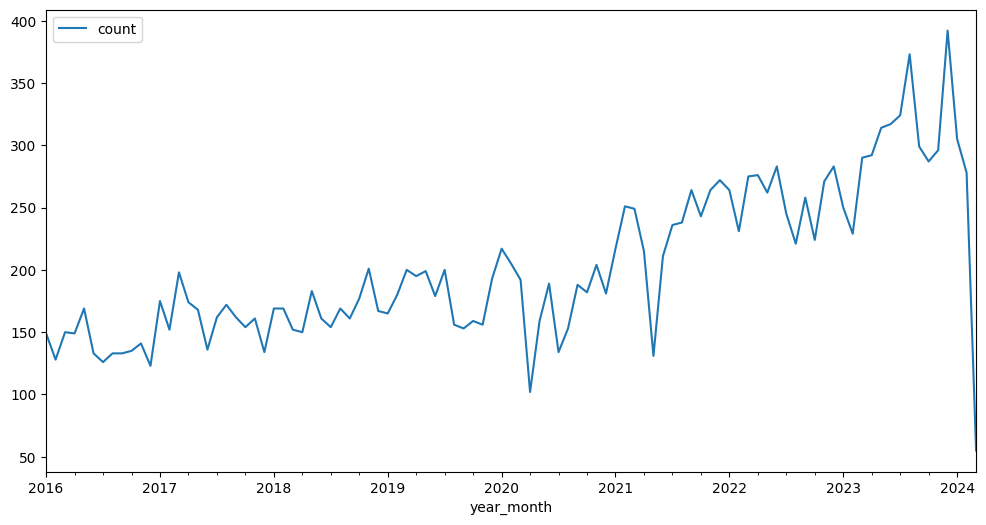

In [39]:
dfkarnatakaposco.plot(figsize=(12,6))

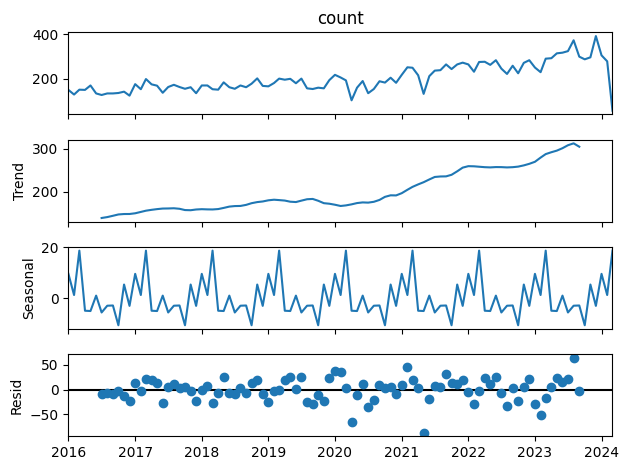

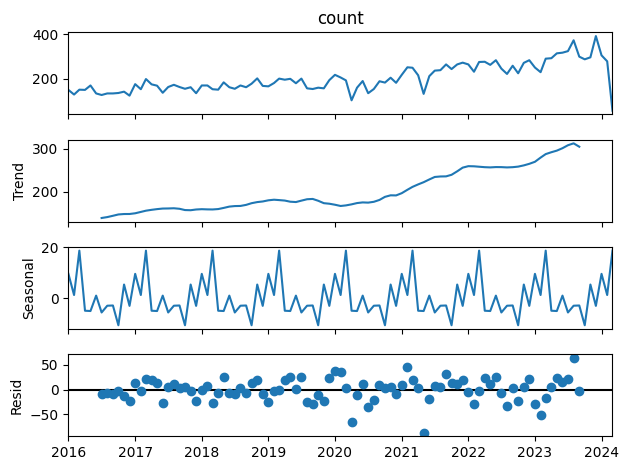

In [40]:
results = seasonal_decompose(dfkarnatakaposco['count'])
results.plot()

In [41]:
len(dfkarnatakaposco)

99

In [42]:
train = dfkarnatakaposco.iloc[:80]
test = dfkarnatakaposco.iloc[80:]

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [44]:
dfkarnatakaposco.head(), dfkarnatakaposco.tail()

(            count
 year_month       
 2016-01-01    149
 2016-02-01    128
 2016-03-01    150
 2016-04-01    149
 2016-05-01    169,
             count
 year_month       
 2023-11-01    296
 2023-12-01    392
 2024-01-01    305
 2024-02-01    278
 2024-03-01     55)

In [45]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [46]:
scaled_train[:10]

array([[0.25966851],
       [0.14364641],
       [0.26519337],
       [0.25966851],
       [0.37016575],
       [0.17127072],
       [0.13259669],
       [0.17127072],
       [0.17127072],
       [0.18232044]])

In [47]:
from keras import preprocessing

In [48]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [49]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [50]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.25966851 0.14364641 0.26519337]
Predict this y: 
 [[0.25966851]]


In [51]:
X.shape

(1, 3, 1)

In [52]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [53]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [54]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

d:\KRK Datathon\datathon\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
41/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3081

d:\KRK Datathon\datathon\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2243
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0408
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276  
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 
Epoch 13/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265
Epoch 14/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224
Epoch 15/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328
Epoch 16/50
68/68 ━━━━━━━━━

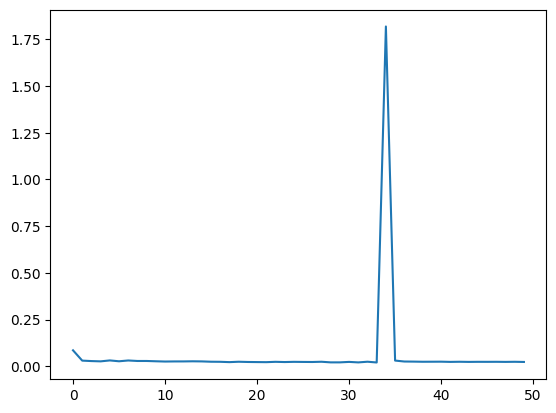

In [57]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [58]:
last_train_batch = scaled_train[-12:]

In [59]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [60]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


array([[0.88948333]], dtype=float32)

In [61]:
scaled_test[0]

array([0.86187845])

In [62]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [63]:
test_predictions

[array([0.88948333], dtype=float32),
 array([0.9005871], dtype=float32),
 array([0.9129187], dtype=float32),
 array([0.9177122], dtype=float32),
 array([0.91784286], dtype=float32),
 array([0.92736626], dtype=float32),
 array([0.94409406], dtype=float32),
 array([0.94689596], dtype=float32),
 array([0.95365226], dtype=float32),
 array([0.95795715], dtype=float32),
 array([0.95633125], dtype=float32),
 array([0.97261965], dtype=float32),
 array([0.9955454], dtype=float32),
 array([1.0074667], dtype=float32),
 array([1.0192219], dtype=float32),
 array([1.0309682], dtype=float32),
 array([1.0435942], dtype=float32),
 array([1.0574249], dtype=float32),
 array([1.0714345], dtype=float32)]

In [64]:
test.head()

,count
year_month,
2022-09-01,258
2022-10-01,224
2022-11-01,271
2022-12-01,283
2023-01-01,250


C:\Users\prana\AppData\Local\Temp\ipykernel_15660\606562851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='year_month'>

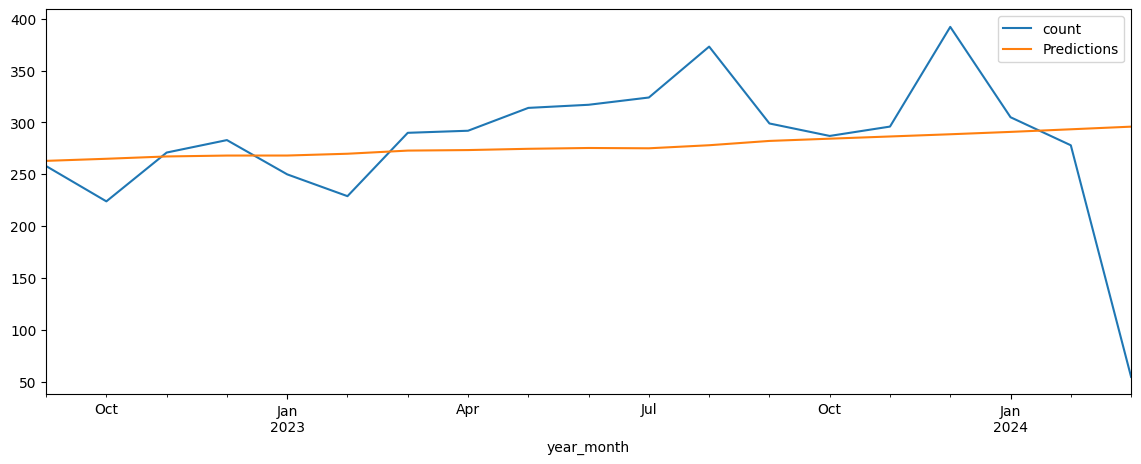

In [65]:
true_predictions = scaler.inverse_transform(test_predictions)
     

test['Predictions'] = true_predictions
     

test.plot(figsize=(14,5))

In [66]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['count'],test['Predictions']))
print(rmse)

68.37374190675908
